<a href="https://colab.research.google.com/github/tina287/DeepGenerativeHomework/blob/main/%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90_%E4%BD%BF%E7%94%A8%E8%AE%8A%E5%88%86%E8%87%AA%E7%B7%A8%E7%A2%BC%E5%99%A8%EF%BC%88VAE%EF%BC%89%E9%87%8D%E5%BB%BA_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 建議用新環境（conda 或 venv 皆可）
!pip install torch torchvision matplotlib



In [3]:
# vae_mnist.py
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# ----------------------------
# 超參數
# ----------------------------
batch_size = 128
epochs = 10
lr = 1e-3
latent_dim = 20
data_root = "/content"  # 放置 MNIST 的根目錄（若手動下載，四個 .gz 放在 ./data/MNIST/raw/）

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# ----------------------------
# Dataset / DataLoader
# 若 ./data/MNIST/raw/ 下已放四個 .gz，download=False 也能正常使用
# ----------------------------
transform = transforms.ToTensor()

raw_dir = os.path.join(data_root, "MNIST", "raw")
has_manual = all(os.path.exists(os.path.join(raw_dir, fn)) for fn in [
    "train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"
])

train_set = datasets.MNIST(
    root=data_root, train=True, transform=transform, download=not has_manual
)
test_set = datasets.MNIST(
    root=data_root, train=False, transform=transform, download=not has_manual
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ----------------------------
# 模型定義：VAE（MLP 版本）
# Encoder: 784 -> 400 -> (mu, logvar)
# Decoder: z -> 400 -> 784 (Sigmoid)
# ----------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        self.fc_dec1 = nn.Linear(latent_dim, 400)
        self.fc_dec2 = nn.Linear(400, 784)

    def encode(self, x):
        # x: [B, 1, 28, 28] -> [B, 784]
        x = x.view(-1, 784)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.fc_dec1(z))
        x_hat = torch.sigmoid(self.fc_dec2(h))  # [B, 784], Sigmoid 對應像素 [0,1]
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ----------------------------
# Loss：重建 (BCE) + KL
# ----------------------------
def vae_loss(recon_x, x, mu, logvar):
    # recon_x: [B, 784], x: [B, 1, 28, 28]
    x = x.view(-1, 784)
    # 使用逐像素 BCE，sum 以符合經典 VAE 公式
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL = -0.5 * Σ(1 + logσ² - μ² - σ²)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl, bce, kl

# ----------------------------
# 訓練與評估
# ----------------------------
def train_one_epoch(epoch):
    model.train()
    total, total_bce, total_kl = 0.0, 0.0, 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss, bce, kl = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        total += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()

    n = len(train_loader.dataset)
    print(f"Epoch {epoch:02d} | loss/px={total/n:.4f} | bce/px={total_bce/n:.4f} | kl/px={total_kl/n:.4f}")

def evaluate_and_save(epoch, tag="final"):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recon, _, _ = model(imgs)

    # 前 8 張做對照
    k = 8
    # 原圖
    grid_in = utils.make_grid(imgs[:k], nrow=k, padding=2)
    # 重建圖
    recon_imgs = recon.view(-1, 1, 28, 28)
    grid_out = utils.make_grid(recon_imgs[:k], nrow=k, padding=2)

    # 存檔（避免無 GUI 環境錯誤）
    os.makedirs("outputs", exist_ok=True)
    utils.save_image(grid_in,  f"outputs/original_{tag}.png")
    utils.save_image(grid_out, f"outputs/recon_{tag}.png")

    # 另外從標準常態取樣產生新圖（可選）
    z = torch.randn(64, latent_dim, device=device)
    with torch.no_grad():
        samples = model.decode(z).view(-1, 1, 28, 28)
    utils.save_image(utils.make_grid(samples, nrow=8), f"outputs/samples_{tag}.png")

if __name__ == "__main__":
    for ep in range(1, epochs + 1):
        train_one_epoch(ep)
    evaluate_and_save(epochs, tag="final")
    print("Done. 圖檔已輸出到 ./outputs/ 目錄下（original_*.png / recon_*.png / samples_*.png）")


100%|██████████| 9.91M/9.91M [00:00<00:00, 33.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | loss/px=165.6825 | bce/px=150.3776 | kl/px=15.3050
Epoch 02 | loss/px=121.8036 | bce/px=99.1282 | kl/px=22.6754
Epoch 03 | loss/px=114.8559 | bce/px=90.5068 | kl/px=24.3491
Epoch 04 | loss/px=111.9637 | bce/px=87.1037 | kl/px=24.8600
Epoch 05 | loss/px=110.1143 | bce/px=84.9750 | kl/px=25.1393
Epoch 06 | loss/px=108.9699 | bce/px=83.6724 | kl/px=25.2975
Epoch 07 | loss/px=108.0992 | bce/px=82.7029 | kl/px=25.3963
Epoch 08 | loss/px=107.4724 | bce/px=81.9925 | kl/px=25.4800
Epoch 09 | loss/px=106.9073 | bce/px=81.4150 | kl/px=25.4923
Epoch 10 | loss/px=106.4846 | bce/px=80.9416 | kl/px=25.5430
Done. 圖檔已輸出到 ./outputs/ 目錄下（original_*.png / recon_*.png / samples_*.png）


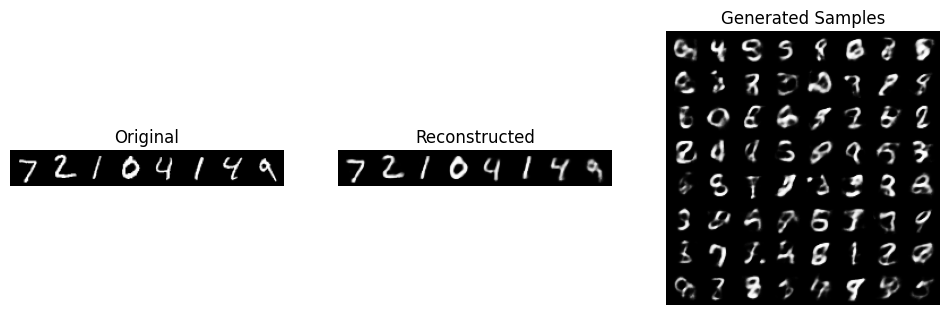

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images():
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for ax, fname, title in zip(
        axs,
        ["outputs/original_final.png", "outputs/recon_final.png", "outputs/samples_final.png"],
        ["Original", "Reconstructed", "Generated Samples"]
    ):
        img = mpimg.imread(fname)
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.show()

# 執行顯示
show_images()
